In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import hydra
from omegaconf import OmegaConf
from hydra import initialize, compose

# custom imports
from src.vae import VariationalAutoencoder, reparameterize
from src.data import HistoDataset, HistoSampler

In [2]:
initialize(config_path="configs/")

config = compose(config_name="train.yaml")

print(config)

{'data_path': '/home/zeynepboztoprak/code/generative-models/project1/data/cell_data.h5', 'train_brains': ['B02', 'B05', 'B07'], 'val_brains': ['B20'], 'test_brains': ['B01'], 'mean': 153.84, 'std': 49.132, 'tile_size': 128, 'lr': 0.001, 'weight_decay': 0.0001, 'latent_dim': 256, 'device': 'cuda', 'batch_size': 64, 'num_workers': 12, 'train_epoch_size': 65536, 'num_epochs': 50, 'log_interval': 100, 'val_epoch_size': 512}


/tmp/ipykernel_209584/2247461055.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs/")


In [8]:
model_state = "outputs/2024-12-03/13-22-01/model_epoch0049.ckpt"
checkpoint = torch.load(model_state)
model = VariationalAutoencoder(latent_dim=config.latent_dim)
model.load_state_dict(checkpoint)
model.eval()
model = model.to(config.device)

Use latent dim of 256


# Task (a) 

(10, 1, 128, 128)


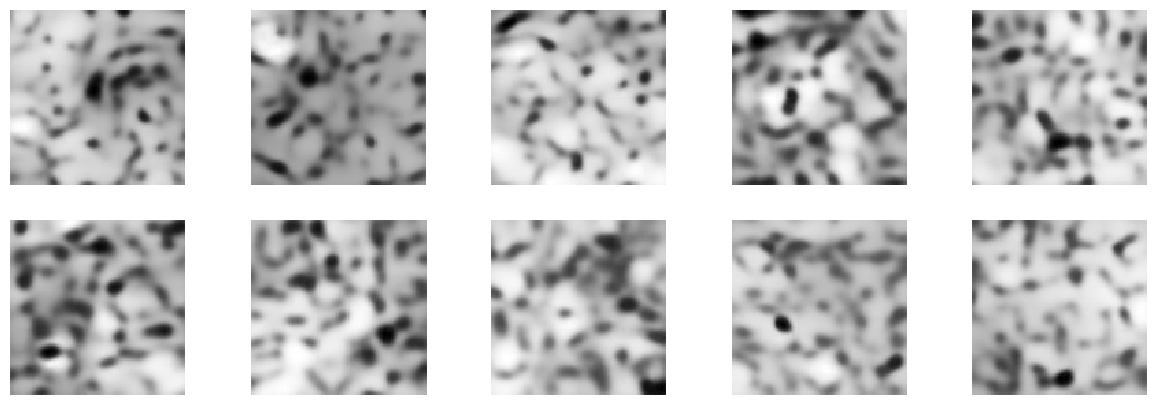

In [9]:
NUM_SAMPLES = 10

latents = torch.randn(NUM_SAMPLES, config.latent_dim)
latents = latents.to(config.device)

predictions = model.decoder(latents).cpu().detach().numpy()
print(predictions.shape)

fig, axes = plt.subplots(2, NUM_SAMPLES // 2, figsize=(15, 5))
axes = axes.flatten()

for i in range(predictions.shape[0]):
    axes[i].imshow(predictions[i].squeeze(), cmap='gray', interpolation='nearest')
    axes[i].axis('off')

plt.show()

# Task (b)

## Same section

In [10]:
def interpolate_latent_vectors(z1, z2, k):
    interpolation = torch.linspace(0, 1, k).unsqueeze(1).to(z1.device)  
    
    z_interpolated = (1 - interpolation) * z1 + interpolation * z2
    
    return z_interpolated

In [11]:
transform = torch.nn.Sequential(transforms.Normalize(config.mean, config.std))

test_brains = ['B01']
sample_images = ['0000']
epoch_length = 2

dataset = HistoDataset(
    file=config.data_path,
    mean=config.mean,
    std=config.std
)

sampler = HistoSampler(
    file=config.data_path,
    tile_size=config.tile_size,
    epoch_length=epoch_length,
    sample_groups=test_brains,
    sample_images=sample_images
)

torch.manual_seed(299793458)

for l in iter(sampler):
    print(l)

Tile(brain='B01', image='0000', row=tensor([494]), column=tensor([382]), tile_size=128)
Tile(brain='B01', image='0000', row=tensor([125]), column=tensor([22]), tile_size=128)


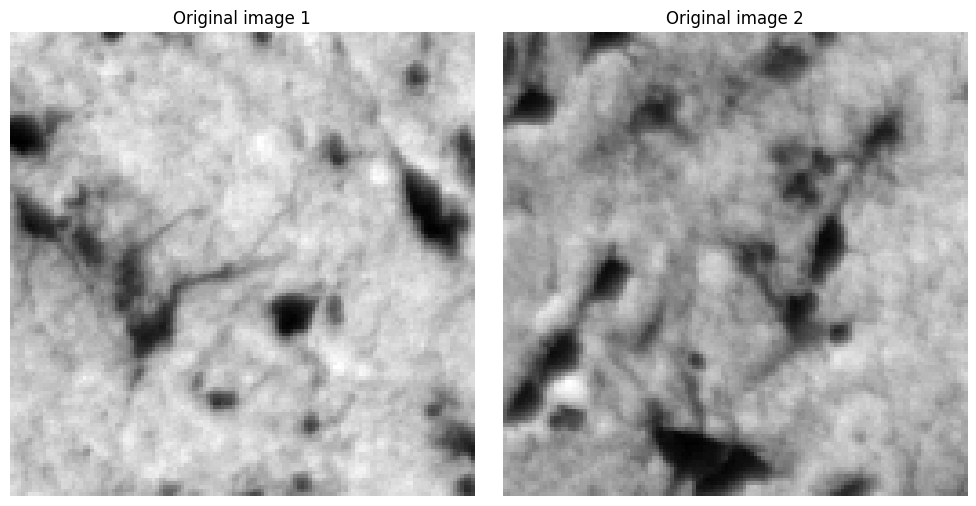

In [12]:
batch_size = 2

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)

example_batch = next(iter(dataloader))

tile1 = example_batch[0,0]
tile2 = example_batch[1,0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(tile1, cmap='gray')
axes[0].set_title('Original image 1')
axes[0].axis('off')  outputs/2024-12-05/13-22-01/model_epoch0049.ckpt

axes[1].imshow(tile2, cmap='gray')
axes[1].set_title('Original image 2')
axes[1].axis('off')  

plt.tight_layout()
plt.show()

/tmp/ipykernel_209584/2060982373.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tile1 = torch.tensor(tile1, dtype=torch.float32)[None]
/tmp/ipykernel_209584/2060982373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tile2 = torch.tensor(tile2, dtype=torch.float32)[None]


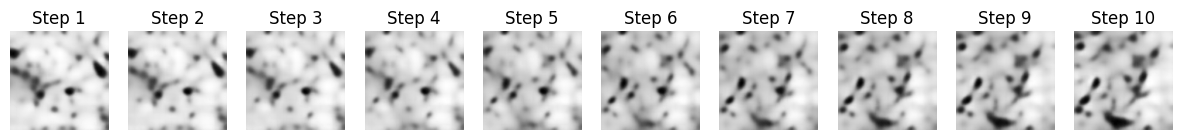

In [13]:
tile1 = torch.tensor(tile1, dtype=torch.float32)[None]
tile2 = torch.tensor(tile2, dtype=torch.float32)[None]

tile1 = tile1.to(config.device).unsqueeze(0)
tile2 = tile2.to(config.device).unsqueeze(0)

mu1, log_var1 = model.encoder(tile1)outputs/2024-12-05/13-22-01/model_epoch0049.ckpt
mu2, log_var2 = model.encoder(tile2)

z1 = reparameterize(mu1, log_var1)
z2 = reparameterize(mu2, log_var2)

z_interpolated = interpolate_latent_vectors(z1, z2, 10)

k = 10
with torch.no_grad():
    decoded_images = model.decoder(z_interpolated)

decoded_images = decoded_images.cpu()

fig, axes = plt.subplots(1, k, figsize=(15, 5))
for i, img in enumerate(decoded_images):
    axes[i].imshow(img.squeeze().numpy(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Step {i+1}")
plt.show()

## Different sections

In [14]:
transform = torch.nn.Sequential(transforms.Normalize(config.mean, config.std))

test_brains = ['B01']
sample_images = ['0000', '0001']
epoch_length = 2

dataset = HistoDataset(
    file=config.data_path,
    mean=config.mean,
    std=config.std
)

sampler = HistoSampler(
    file=config.data_path,
    tile_size=config.tile_size,
    epoch_length=epoch_length,
    sample_groups=test_brains,
    sample_images=sample_images
)

torch.manual_seed(294793458)

for l in iter(sampler):
    print(l)

Tile(brain='B01', image='0000', row=tensor([269]), column=tensor([468]), tile_size=128)
Tile(brain='B01', image='0001', row=tensor([148]), column=tensor([284]), tile_size=128)


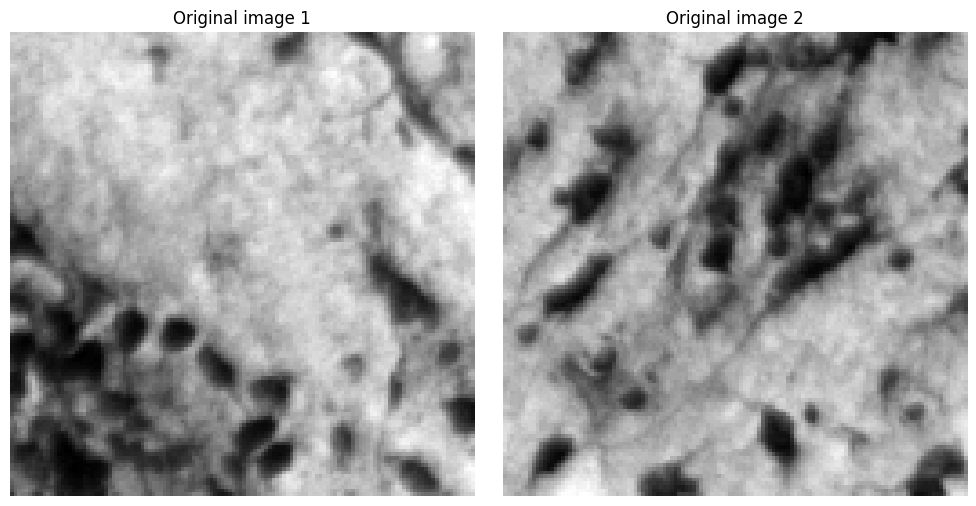

In [15]:
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)

example_batch = next(iter(dataloader))

tile1 = example_batch[0,0]
tile2 = example_batch[1,0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(tile1, cmap='gray')
axes[0].set_title('Original image 1')
axes[0].axis('off')  

axes[1].imshow(tile2, cmap='gray')
axes[1].set_title('Original image 2')
axes[1].axis('off')  

plt.tight_layout()
plt.show()

/tmp/ipykernel_209584/2060982373.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tile1 = torch.tensor(tile1, dtype=torch.float32)[None]
/tmp/ipykernel_209584/2060982373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tile2 = torch.tensor(tile2, dtype=torch.float32)[None]


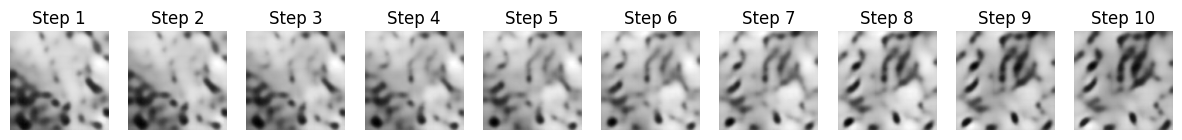

In [16]:
tile1 = torch.tensor(tile1, dtype=torch.float32)[None]
tile2 = torch.tensor(tile2, dtype=torch.float32)[None]

tile1 = tile1.to(config.device).unsqueeze(0)
tile2 = tile2.to(config.device).unsqueeze(0)

mu1, log_var1 = model.encoder(tile1)
mu2, log_var2 = model.encoder(tile2)

z1 = reparameterize(mu1, log_var1)
z2 = reparameterize(mu2, log_var2)

z_interpolated = interpolate_latent_vectors(z1, z2, 10)

k = 10
with torch.no_grad():
    decoded_images = model.decoder(z_interpolated)

decoded_images = decoded_images.cpu()

fig, axes = plt.subplots(1, k, figsize=(15, 5))
for i, img in enumerate(decoded_images):
    axes[i].imshow(img.squeeze().numpy(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Step {i+1}")
plt.show()

# Task (c)

In [17]:
sampler = HistoSampler(
    file=config.data_path,
    tile_size=config.tile_size,
    epoch_length=3000,
    sample_groups=test_brains
)

dataloader = DataLoader(dataset=dataset, sampler=sampler, batch_size=config.batch_size)

In [18]:
model = model.to(config.device)
model.eval()

latent_features = []

with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(config.device)
        mu, log_var = model.encoder(batch)
        z = reparameterize(mu, log_var)
        latent_features.append(z.cpu().numpy())

latent_features = np.concatenate(latent_features, axis=0)
print(latent_features.shape)

(3000, 256)


In [19]:
reducer = PCA(n_components=2)

pca_proj = reducer.fit_transform(latent_features)

np.sum(reducer.explained_variance_ratio_)

0.027097106

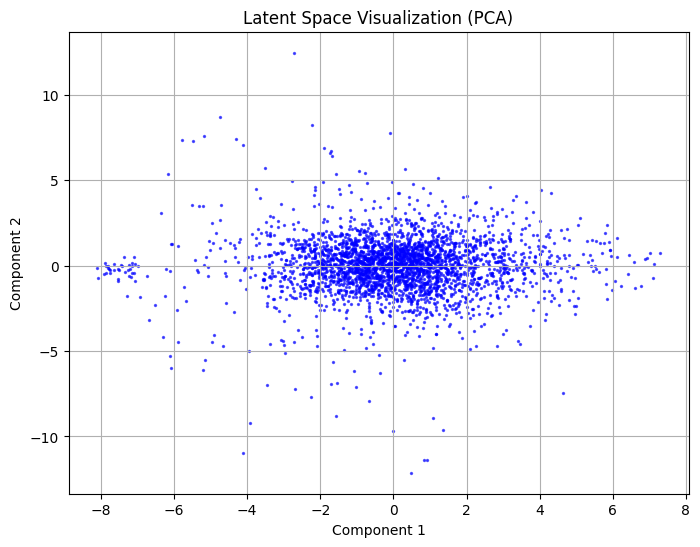

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], s=2, alpha=0.6, c='blue')
plt.title(f"Latent Space Visualization (PCA)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()